In [15]:
# # # TODO: The threshold of 0.5 is arbitrary and might need to be adjusted based on your specific dataset and the model you are using. For some models, even moderately correlated features might pose problems, while for others, even higher correlations might not be as concerning.
# # # TODO: As a baseline model we can also use a model that has built-in mechanisms for feature selection (like L1 regularization for linear models). 
# # # TODO: Saga: Not checking missing values, outliers, or other data quality issues, imbalanced dataset. These can also affect the model's performance and should be addressed before or during feature selection.

In [106]:
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.preprocessing import StandardScaler
# define a XGBoost classifier
import xgboost as xgb
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin


warnings.filterwarnings("ignore")  # Ignore runtime warnings
# Temporarily adjust pandas display settings for large DataFrames
pd.set_option('display.max_rows', 100)  # Ensure 100 rows can be displayed
pd.set_option('display.max_columns', None)  # Ensure all columns can be displayed
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Ensure full width of column content is shown
pd.set_option('display.float_format', '{:.4f}'.format)  # Format the float numbers for better readability

# Data preprocessing and feature selection

Our data consists of binary data so we only want to calculate the Z-score for non-binary colomns

In [17]:
# Load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

Before cleaning:
Missing values per column:
Total missing values: 0


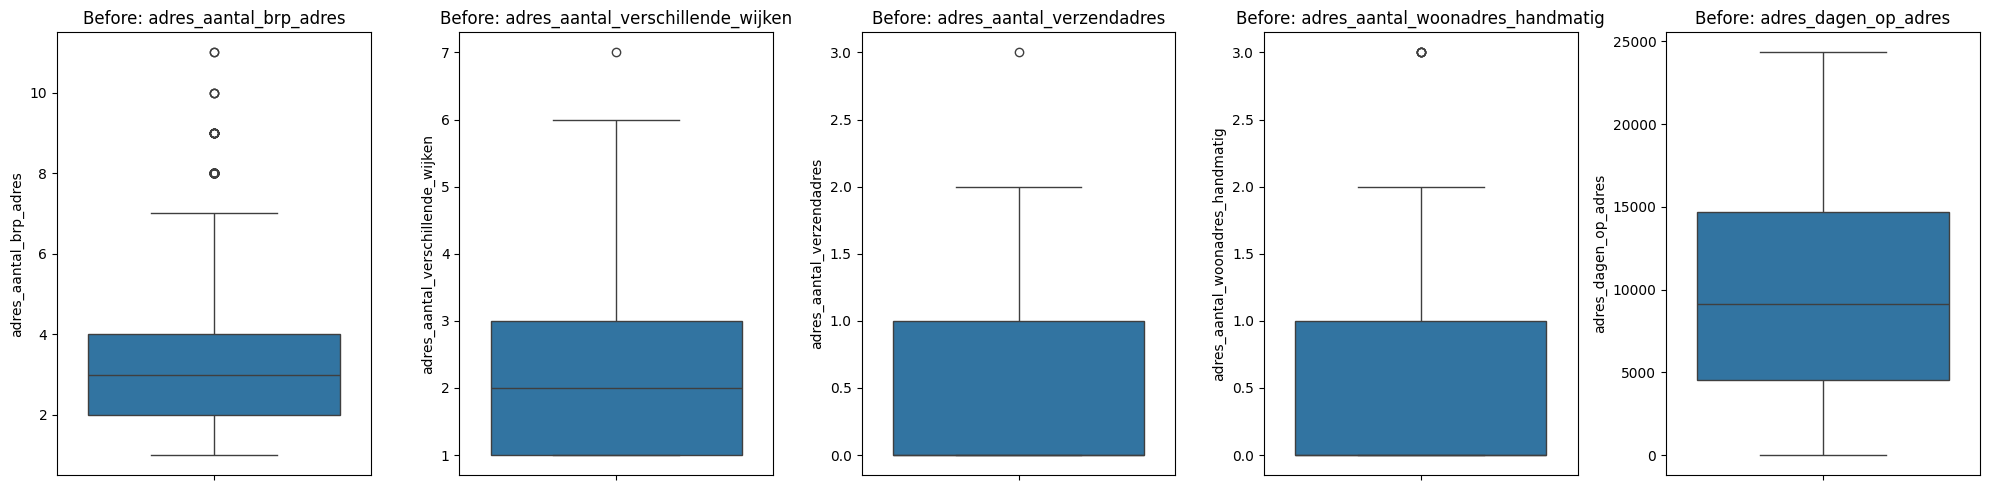

After cleaning:
Missing values per column:
Total missing values: 0


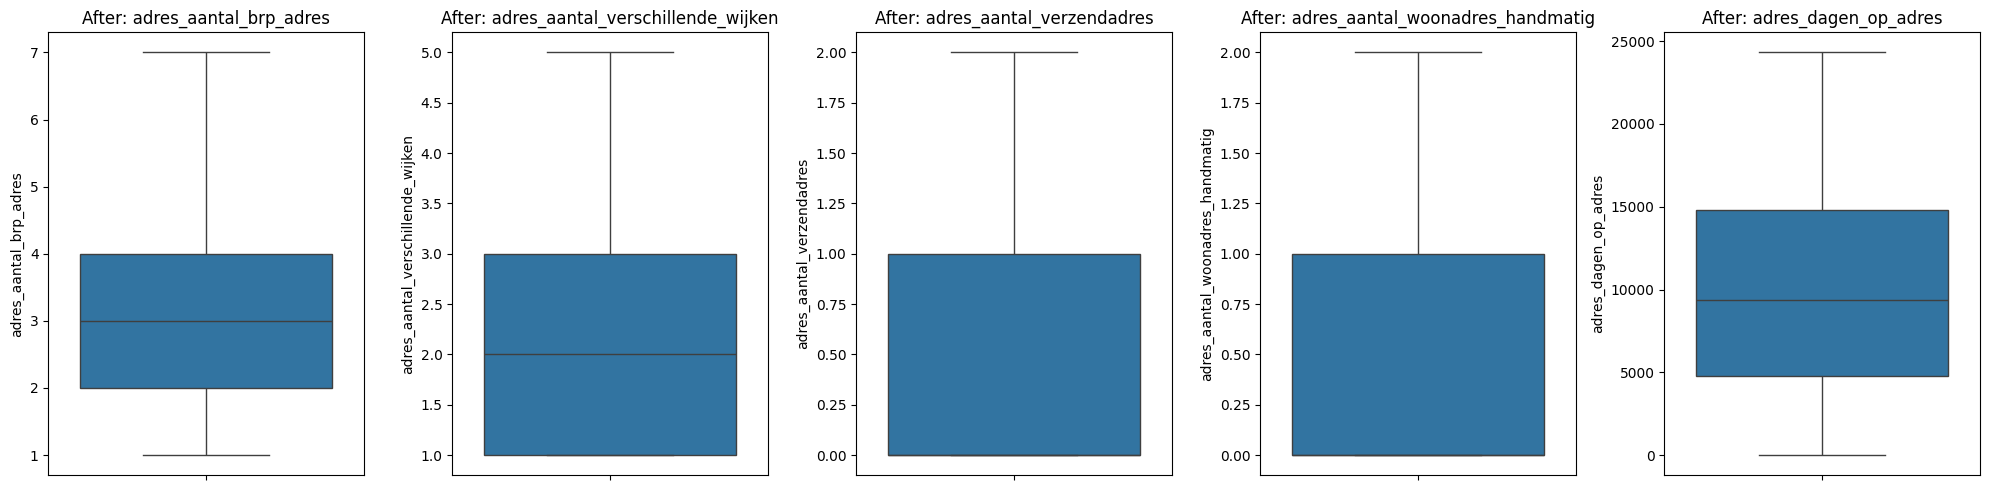

Shape before cleaning: (12645, 316)
Shape after cleaning: (10182, 316)


In [18]:
print("Before cleaning:")
print("Missing values per column:")
print("Total missing values:", data.isna().sum().sum())

# Identify non-binary columns
non_binary_columns = [col for col in data.columns if not (np.isin(data[col].unique(), [0, 1]).all() and len(data[col].unique()) == 2)]

# Calculate Z-scores for non-binary columns only
z_scores_non_binary = np.abs(stats.zscore(data[non_binary_columns], nan_policy='omit'))

# Mask to identify rows with outliers in non-binary columns
outlier_mask = (z_scores_non_binary > 3.5).any(axis=1)

# Select a subset of non-binary columns for plotting to avoid large image sizes
plot_columns = non_binary_columns[:5]  # Adjust this number based on your specific needs

# Plot outliers for the selected columns before removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data[col])
    plt.title(f'Before: {col}')
plt.tight_layout()
plt.show()

# Remove outliers from the dataset using the previously defined full_outlier_mask
data_cleaned = data[~outlier_mask]

print("After cleaning:")
print("Missing values per column:")
print("Total missing values:", data_cleaned.isna().sum().sum())

# Plot outliers for the selected columns after removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'After: {col}')
plt.tight_layout()
plt.show()

# Print the shape of the dataset before and after cleaning
print("Shape before cleaning:", data.shape)
print("Shape after cleaning:", data_cleaned.shape)

In [110]:
def filter_non_fair_features(df):
    non_fair_keywords = [
        "adres", "woonadres", "verzendadres", "buurt", "wijk", "plaats", "persoon_geslacht_vrouw", "taal", "kind"
        , "ontheffing"
    ]
    # Optionally, define keywords for features you want to ensure are included
    fair_inclusion_keywords = [
        "medische_omstandigheden", "sociaal_maatschappelijke_situatie"
    ]

    # Maak de controle case-insensitive
    non_fair_keywords = [keyword.lower() for keyword in non_fair_keywords]
    fair_inclusion_keywords = [keyword.lower() for keyword in fair_inclusion_keywords]

    # Filter features, ensuring that certain conditions are met for inclusion or exclusion
    fair_features = [feature for feature in df.columns if not any(nfk in feature.lower() for nfk in non_fair_keywords) or any(fik in feature.lower() for fik in fair_inclusion_keywords)]
    
    # Keep list of removed features
    removed_features = [feature for feature in df.columns if feature not in fair_features]
    
    # Retourneer een DataFrame met alleen de FAIR features
    return df[fair_features], removed_features


# Pas de filter toe op de DataFrame
data_reduced, removed_features = filter_non_fair_features(data_cleaned)

# print all kolomn that are removed
print("Removed features:")
for feature in removed_features:
    print(feature)

# # Print alle kolomnamen van de gefilterde DataFrame
print("\n\n\nRemaining features:")
for col in data_reduced.columns:
    print(col)
    
# Print the shape of the dataset before and after filtering
print("\nShape before filtering:", data_cleaned.shape)
print("Shape after filtering:", data_reduced.shape)



class FeatureFilter(BaseEstimator, TransformerMixin):
    def __init__(self, non_fair_keywords):
        self.non_fair_keywords = non_fair_keywords
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Make the keywords case-insensitive
        non_fair_keywords = [keyword.lower() for keyword in self.non_fair_keywords]

        # Filter features based on non-fair keywords
        fair_features = [feature for feature in X.columns if not any(nfk in feature.lower() for nfk in non_fair_keywords)]

        # Keep track of removed features
        self.removed_features = [feature for feature in X.columns if feature not in fair_features]

        # Return DataFrame with only the fair features
        return X[fair_features]

# Define non-fair keywords
non_fair_keywords = [
    "adres", "woonadres", "verzendadres", "buurt", "wijk", "plaats", "persoon_geslacht_vrouw", "taal", "kind", "ontheffing"
]

Removed features:
adres_aantal_brp_adres
adres_aantal_verschillende_wijken
adres_aantal_verzendadres
adres_aantal_woonadres_handmatig
adres_dagen_op_adres
adres_recentst_onderdeel_rdam
adres_recentste_buurt_groot_ijsselmonde
adres_recentste_buurt_nieuwe_westen
adres_recentste_buurt_other
adres_recentste_buurt_oude_noorden
adres_recentste_buurt_vreewijk
adres_recentste_plaats_other
adres_recentste_plaats_rotterdam
adres_recentste_wijk_charlois
adres_recentste_wijk_delfshaven
adres_recentste_wijk_feijenoord
adres_recentste_wijk_ijsselmonde
adres_recentste_wijk_kralingen_c
adres_recentste_wijk_noord
adres_recentste_wijk_other
adres_recentste_wijk_prins_alexa
adres_recentste_wijk_stadscentru
adres_unieke_wijk_ratio
afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel
afspraak_afgelopen_jaar_ontheffing
afspraak_afgelopen_jaar_ontheffing_taaleis
afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis
belemmering_hist_taal
contacten_onderwe

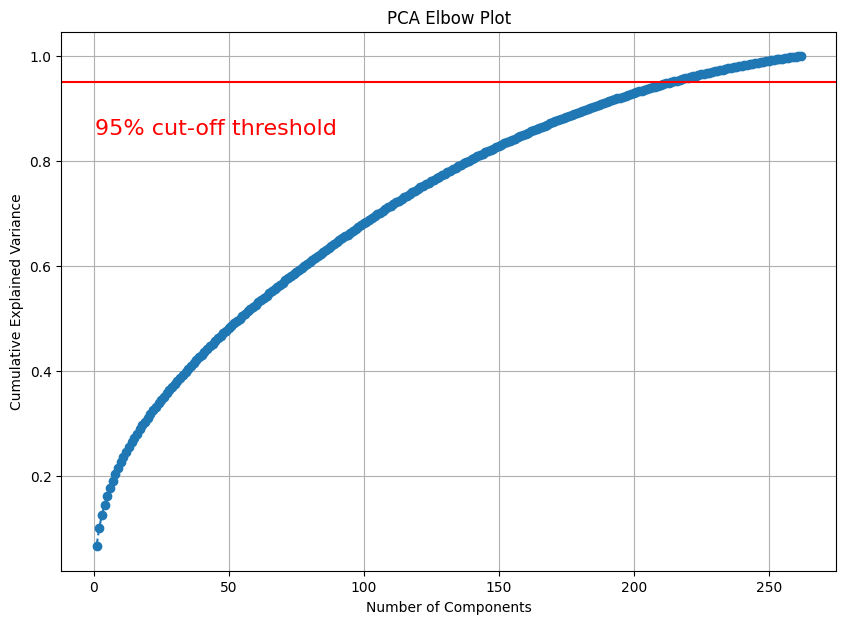

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Assuming data_reduced_scaled is already your standardized data
# Standardize the Data (you've already done this part)
scaler = StandardScaler()
data_reduced_scaled = scaler.fit_transform(data_reduced)

# Determine the number of components
pca = PCA().fit(data_reduced_scaled)

# Calculate the cumulative sum of explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the elbow plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('PCA Elbow Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

# Optional: Add a threshold line, e.g., 0.95 for 95% explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

plt.show()

In [21]:
# Assuming data_reduced_scaled is your standardized data
# Perform PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
data_reduced_pca = pca.fit_transform(data_reduced_scaled)

# Convert the PCA result back into a pandas DataFrame
# Create column names based on the number of selected components
columns = [f'PC{i+1}' for i in range(data_reduced_pca.shape[1])]
data_reduced_df = pd.DataFrame(data_reduced_pca, columns=columns)

In [84]:
# Check how imbalance the dataset is
data_reduced['checked'].value_counts(normalize=True)

checked
0   0.9066
1   0.0934
Name: proportion, dtype: float64

In [98]:
# Let's specify the features and the target
y = data_cleaned['checked']
X = data_cleaned.drop(['checked'], axis=1)
X = X.astype(np.float32)

# TODO: Instead of a single train-test split, consider using cross-validation to assess model performance more robustly. This approach can help ensure the model's generalizability across different subsets of our data.
# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

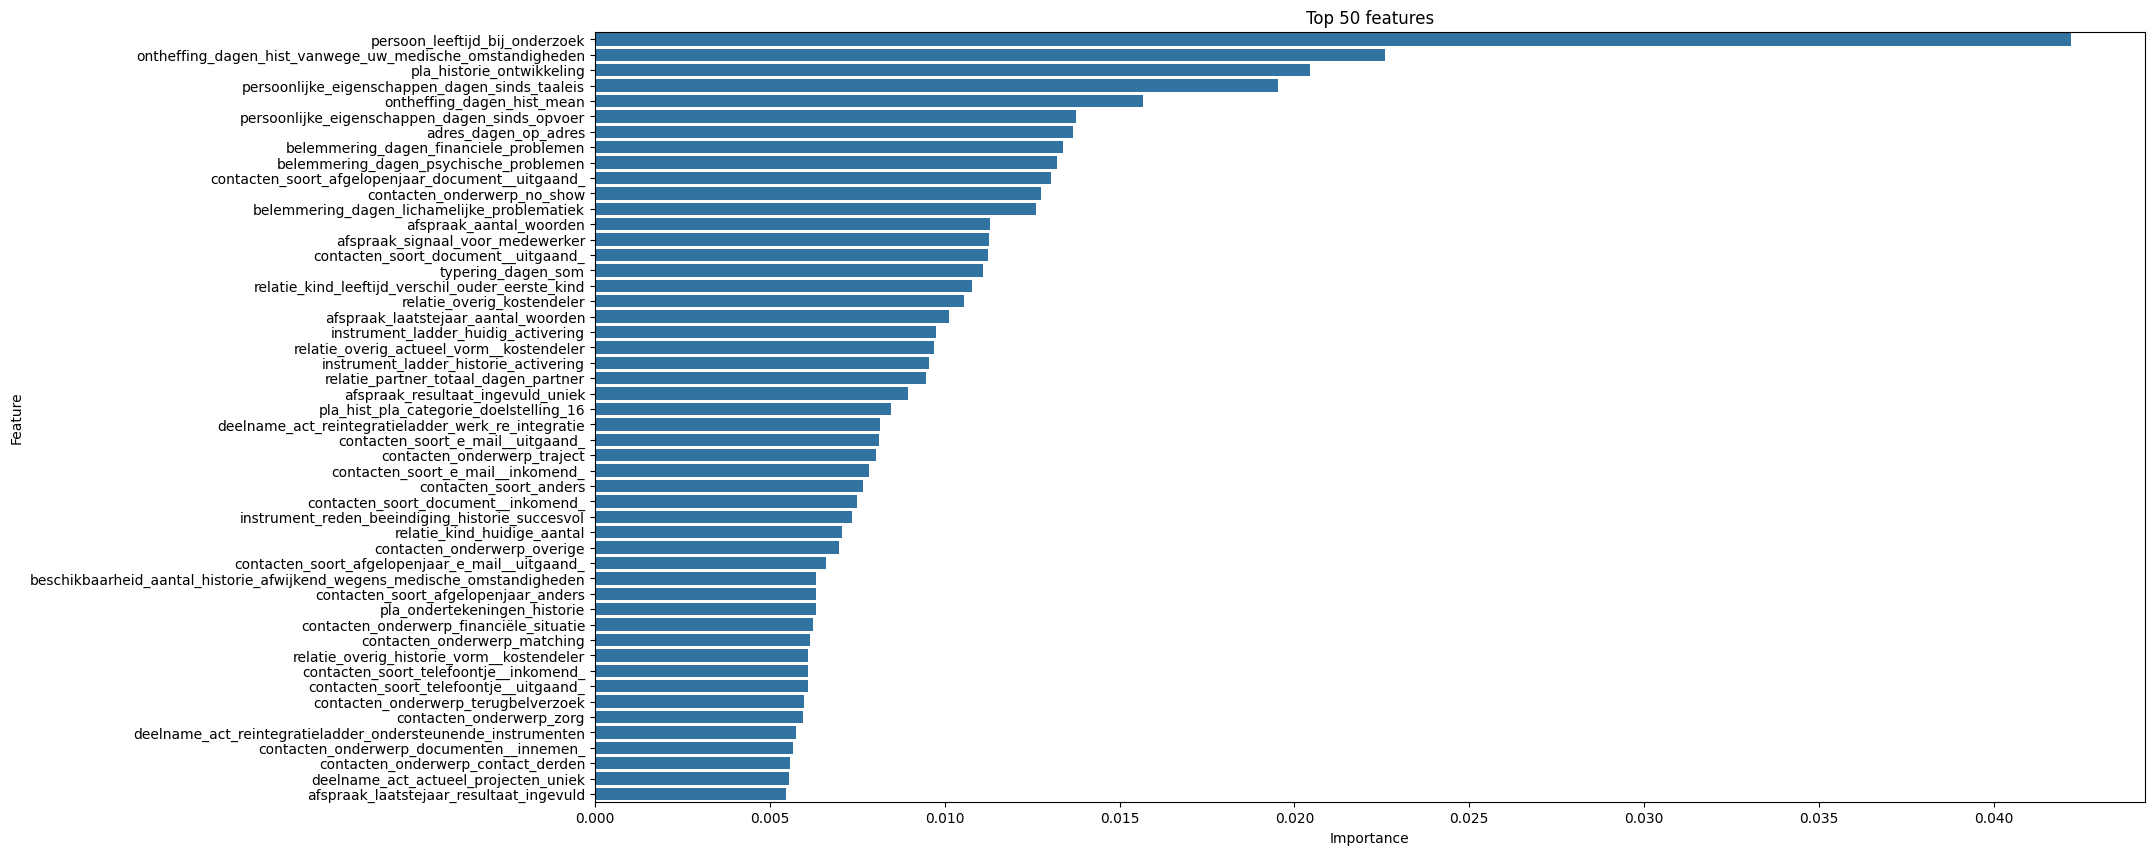

In [99]:
# TODO: Further explore feature engineering possibilities. Creating new features based on domain knowledge can provide the model with additional insights, potentially improving performance

# Initializing and training the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Getting feature importances
feature_importances = clf.feature_importances_

# Converting feature importances into a more readable format
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_sorted = features.sort_values(by='Importance', ascending=False)

# Plotting the top 50 features
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=features_sorted.head(50))
plt.title('Top 50 features')
plt.show()

# Feature scaling and model training

In [101]:
classifier = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=1,
    use_label_encoder=False,  # To avoid warning
    eval_metric='logloss',  # Evaluation metric to avoid warning
    random_state=0
)

In [113]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
# TODO: The pipeline construction and inclusion of feature scaling via StandardScaler is a good practice, ensuring that your model is not biased by the scale of the features.
pipeline_steps = [
    ('filter_features', FeatureFilter(non_fair_keywords)),  # Filter non-fair features
    ('scaler', StandardScaler()),  # First, scale the features
    ('pca', PCA(n_components=0.95)),  # Then, apply PCA to reduce dimensionality, retaining 95% variance
    ('classification', classifier)  # Finally, use the classifier for prediction
]

pipeline = Pipeline(steps=pipeline_steps)

# Let's train a simple model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('filter_features',
                 FeatureFilter(non_fair_keywords=['adres', 'woonadres',
                                                  'verzendadres', 'buurt',
                                                  'wijk', 'plaats',
                                                  'persoon_geslacht_vrouw',
                                                  'taal', 'kind',
                                                  'ontheffing'])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('classification',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

Accuracy: 0.8724
Precision: 0.3801
Recall: 0.5842
F1 Score: 0.4606
Adjusted Accuracy: 0.9072
Adjusted Precision: 1.0000
Adjusted Recall: 0.0053
Adjusted F1 Score: 0.0105


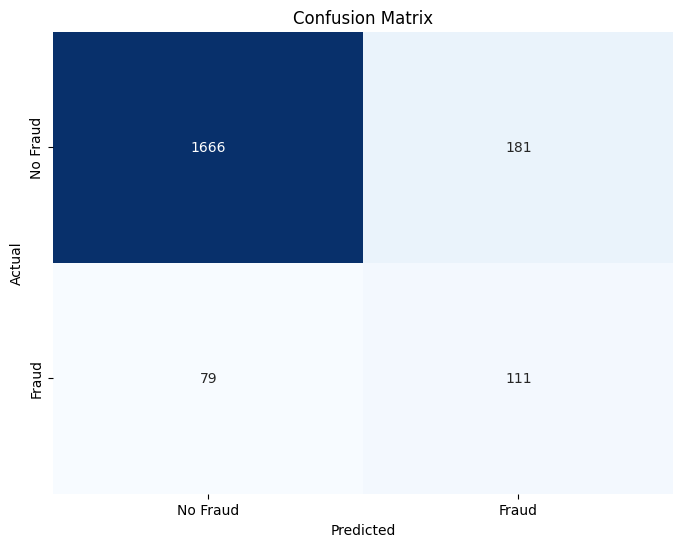

In [97]:
# TODO: Our evaluation focuses on accuracy, which is a good starting point. However, for fraud detection, other metrics like Precision, Recall, F1 Score, or even a custom cost function might be more appropriate due to the typically imbalanced nature of fraud data. This helps ensure you're not only capturing the fraud cases accurately but also minimizing false positives which can be costly or disruptive.
# Let's evaluate the model
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

# print confusion matrix
from sklearn.metrics import confusion_matrix


# Adjust the classification threshold
threshold = 0.9  # Set this to the new threshold you want to test
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Apply the new threshold to make predictions

# Evaluate the adjusted predictions
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)

print(f'Adjusted Accuracy: {accuracy_adjusted:.4f}')
print(f'Adjusted Precision: {precision_adjusted:.4f}')
print(f'Adjusted Recall: {recall_adjusted:.4f}')
print(f'Adjusted F1 Score: {f1_adjusted:.4f}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [69]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

MissingShapeCalculator: Unable to find a shape calculator for type '<class 'xgboost.sklearn.XGBClassifier'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


In [ ]:
# Let's save the model
onnx.save(onnx_model, "model/good_model.onnx")

# Let's load the model
new_session = rt.InferenceSession("model/good_model.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


In [83]:
# Testing, how are we supposed to test if the input features are different??
first_sample = data.iloc[[0]]

# Create a copy of the first sample and flip the boolean value of persoon_geslacht_vrouw
flipped_sample = first_sample.copy()
print(flipped_sample['persoon_geslacht_vrouw'])
flipped_sample['persoon_geslacht_vrouw'] = ~flipped_sample['persoon_geslacht_vrouw']

# Concatenate the original and the modified samples
new_X_test = pd.concat([first_sample, flipped_sample], ignore_index=True)
new_y_pred = pipeline.predict(new_X_test)
print(new_y_pred)

0    0
Name: persoon_geslacht_vrouw, dtype: int64


ValueError: feature_names mismatch: ['afspraak_aanmelding_afgesloten', 'afspraak_aantal_woorden', 'afspraak_afgelopen_jaar_afsprakenplan', 'afspraak_afgelopen_jaar_plan_van_aanpak', 'afspraak_afgelopen_jaar_signaal_voor_medewerker', 'afspraak_afgelopen_jaar_vervolgmeting_matchbaarheid_werkzoekende_klant', 'afspraak_afgelopen_jaar_voortgang_aanmelding_en_deelname', 'afspraak_afsprakenplan', 'afspraak_controle_aankondiging_maatregel', 'afspraak_controle_verwijzing', 'afspraak_deelname_compleet_uit_webapplicatie', 'afspraak_galo_gesprek', 'afspraak_gespr__einde_zoekt___galo_gesprek_', 'afspraak_inspanningsperiode', 'afspraak_laatstejaar_aantal_woorden', 'afspraak_laatstejaar_resultaat_ingevuld', 'afspraak_laatstejaar_resultaat_ingevuld_uniek', 'afspraak_other', 'afspraak_participatietrede_vervolgmeting', 'afspraak_resultaat_ingevuld_uniek', 'afspraak_signaal_van_aanbieder', 'afspraak_signaal_voor_medewerker', 'afspraak_toevoegen_inschrijving_uwvwb', 'afspraak_vervolgmeting_matchbaarheid_werkzoekende_klant', 'afspraak_voortgangsgesprek', 'belemmering_aantal_huidig', 'belemmering_dagen_financiele_problemen', 'belemmering_dagen_lichamelijke_problematiek', 'belemmering_dagen_psychische_problemen', 'belemmering_financiele_problemen', 'belemmering_hist_lichamelijke_problematiek', 'belemmering_hist_psychische_problemen', 'belemmering_hist_stabiele_mix__sz____dagbesteding_werk', 'belemmering_hist_verslavingsproblematiek', 'belemmering_ind', 'belemmering_ind_hist', 'belemmering_niet_computervaardig', 'belemmering_psychische_problemen', 'belemmering_woonsituatie', 'beschikbaarheid_aantal_historie_afwijkend_wegens_medische_omstandigheden', 'beschikbaarheid_aantal_historie_afwijkend_wegens_sociaal_maatschappelijke_situatie', 'beschikbaarheid_huidig_afwijkend_wegens_medische_omstandigheden', 'beschikbaarheid_huidig_bekend', 'beschikbaarheid_recent_afwijkend_wegens_medische_omstandigheden', 'beschikbaarheid_recent_afwijkend_wegens_sociaal_maatschappelijke_situatie', 'competentie_aansturen', 'competentie_analyseren', 'competentie_ethisch_en_integer_handelen', 'competentie_formuleren_en_rapporteren', 'competentie_gedrevenheid_en_ambitie_tonen', 'competentie_instructies_en_procedures_opvolgen', 'competentie_kwaliteit_leveren', 'competentie_leren', 'competentie_materialen_en_middelen_inzetten', 'competentie_met_druk_en_tegenslag_omgaan', 'competentie_omgaan_met_verandering_en_aanpassen', 'competentie_onderzoeken', 'competentie_op_de_behoeften_en_verwachtingen_van_de__klant__richten', 'competentie_other', 'competentie_overtuigen_en_beïnvloeden', 'competentie_plannen_en_organiseren', 'competentie_samenwerken_en_overleggen', 'competentie_vakdeskundigheid_toepassen', 'contacten_onderwerp__arbeids_motivatie', 'contacten_onderwerp__pre__intake', 'contacten_onderwerp__werk_intake', 'contacten_onderwerp_arbeidsdiagnose_dariuz', 'contacten_onderwerp_boolean__arbeids_motivatie', 'contacten_onderwerp_boolean__pre__intake', 'contacten_onderwerp_boolean__werk_intake', 'contacten_onderwerp_boolean_contact_derden', 'contacten_onderwerp_boolean_contact_met_aanbieder', 'contacten_onderwerp_boolean_diagnosegesprek', 'contacten_onderwerp_boolean_documenten__innemen_', 'contacten_onderwerp_boolean_documenttype__cv_', 'contacten_onderwerp_boolean_documenttype__diploma_s_en_certificaten_', 'contacten_onderwerp_boolean_documenttype__overeenkomst_', 'contacten_onderwerp_boolean_financiële_situatie', 'contacten_onderwerp_boolean_groepsbijeenkomst', 'contacten_onderwerp_boolean_inkomen', 'contacten_onderwerp_boolean_maatregel_overweging', 'contacten_onderwerp_boolean_match___werk', 'contacten_onderwerp_boolean_matching', 'contacten_onderwerp_boolean_motivatie', 'contacten_onderwerp_boolean_mutatie', 'contacten_onderwerp_boolean_no_show', 'contacten_onderwerp_boolean_overige', 'contacten_onderwerp_boolean_overleg_met_inkomen', 'contacten_onderwerp_boolean_scholing', 'contacten_onderwerp_boolean_sollicitatie', 'contacten_onderwerp_boolean_terugbelverzoek', 'contacten_onderwerp_boolean_traject', 'contacten_onderwerp_boolean_uitnodiging', 'contacten_onderwerp_boolean_ziek__of_afmelding', 'contacten_onderwerp_boolean_zorg', 'contacten_onderwerp_contact_derden', 'contacten_onderwerp_contact_met_aanbieder', 'contacten_onderwerp_diagnosegesprek', 'contacten_onderwerp_documenten__innemen_', 'contacten_onderwerp_documenttype__cv_', 'contacten_onderwerp_documenttype__overeenkomst_', 'contacten_onderwerp_financiële_situatie', 'contacten_onderwerp_groepsbijeenkomst', 'contacten_onderwerp_inkomen', 'contacten_onderwerp_inname_aanvraag', 'contacten_onderwerp_inspanningstoets', 'contacten_onderwerp_maatregel_overweging', 'contacten_onderwerp_matching', 'contacten_onderwerp_mutatie', 'contacten_onderwerp_no_show', 'contacten_onderwerp_overige', 'contacten_onderwerp_overleg_met_inkomen', 'contacten_onderwerp_quickscan', 'contacten_onderwerp_scholing', 'contacten_onderwerp_screening', 'contacten_onderwerp_terugbelverzoek', 'contacten_onderwerp_traject', 'contacten_onderwerp_uitnodiging', 'contacten_onderwerp_vakantie', 'contacten_onderwerp_werkintake__niet_verschenen', 'contacten_onderwerp_ziek__of_afmelding', 'contacten_onderwerp_zorg', 'contacten_soort_afgelopenjaar_anders', 'contacten_soort_afgelopenjaar_document__inkomend_', 'contacten_soort_afgelopenjaar_document__uitgaand_', 'contacten_soort_afgelopenjaar_e_mail__inkomend_', 'contacten_soort_afgelopenjaar_e_mail__uitgaand_', 'contacten_soort_afgelopenjaar_gesprek', 'contacten_soort_afgelopenjaar_gesprek_op_locatie', 'contacten_soort_afgelopenjaar_rapportage_rib', 'contacten_soort_afgelopenjaar_telefoontje__inkomend_', 'contacten_soort_afgelopenjaar_telefoontje__uitgaand_', 'contacten_soort_anders', 'contacten_soort_document__inkomend_', 'contacten_soort_document__uitgaand_', 'contacten_soort_e_mail__inkomend_', 'contacten_soort_e_mail__uitgaand_', 'contacten_soort_gesprek_op_locatie', 'contacten_soort_groepsbijeenkomsten', 'contacten_soort_rapportage_deelname', 'contacten_soort_rapportage_rib', 'contacten_soort_telefoontje__inkomend_', 'contacten_soort_telefoontje__uitgaand_', 'deelname_act_actueel_projecten_uniek', 'deelname_act_hist_projecten_niet_gestart', 'deelname_act_reintegratieladder_ondersteunende_instrumenten', 'deelname_act_reintegratieladder_werk_re_integratie', 'instrument_aantal_laatstejaar', 'instrument_ladder_historie_activering', 'instrument_ladder_historie_other', 'instrument_ladder_huidig_activering', 'instrument_ladder_huidig_other', 'instrument_ladder_huidig_werk_re_integratie', 'instrument_reden_beeindiging_historie_centrale_actie_wigo4it', 'instrument_reden_beeindiging_historie_diagnose_gesteld', 'instrument_reden_beeindiging_historie_direct_matchbaar', 'instrument_reden_beeindiging_historie_doelstelling_bereikt__geen_uitstroom', 'instrument_reden_beeindiging_historie_doelstelling_bereikt__uitstroom_naar_regulier_werk', 'instrument_reden_beeindiging_historie_doelstelling_bereikt__uitstroom_overig', 'instrument_reden_beeindiging_historie_doelstelling_niet_bereikt__geen_uitstroom', 'instrument_reden_beeindiging_historie_niet_matchbaar', 'instrument_reden_beeindiging_historie_niet_succesvol', 'instrument_reden_beeindiging_historie_niet_succesvol__reden_bij_werkzoekende', 'instrument_reden_beeindiging_historie_op_termijn_matchbaar', 'instrument_reden_beeindiging_historie_other', 'instrument_reden_beeindiging_historie_overdracht_naar_mo', 'instrument_reden_beeindiging_historie_overdracht_naar_prematching', 'instrument_reden_beeindiging_historie_overdracht_naar_regulier_team_iwpm', 'instrument_reden_beeindiging_historie_overdracht_succesvol', 'instrument_reden_beeindiging_historie_succesvol', 'instrument_reden_beeindiging_historie_succesvol__doelstelling_bereikt', 'instrument_reden_beeindiging_historie_uitval__aanbod_niet_langer_zinvol_volgens_gemeente', 'instrument_reden_beeindiging_historie_uitval__klant_wz__ziet_af_van_aanbod', 'ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden', 'ontheffing_reden_hist_vanwege_uw_sociaal_maatschappelijke_situatie', 'persoon_leeftijd_bij_onderzoek', 'persoonlijke_eigenschappen_communicatie_opm', 'persoonlijke_eigenschappen_dagen_sinds_opvoer', 'persoonlijke_eigenschappen_doorzettingsvermogen_opm', 'persoonlijke_eigenschappen_flexibiliteit_opm', 'persoonlijke_eigenschappen_hobbies_sport', 'persoonlijke_eigenschappen_houding_opm', 'persoonlijke_eigenschappen_ind_activering_traject', 'persoonlijke_eigenschappen_ind_buiten_kantoortijden', 'persoonlijke_eigenschappen_ind_regulier_arbeidsritme', 'persoonlijke_eigenschappen_initiatief_opm', 'persoonlijke_eigenschappen_leergierigheid_opm', 'persoonlijke_eigenschappen_motivatie_opm', 'persoonlijke_eigenschappen_nl_begrijpen3', 'persoonlijke_eigenschappen_nl_lezen3', 'persoonlijke_eigenschappen_nl_lezen4', 'persoonlijke_eigenschappen_nl_schrijven0', 'persoonlijke_eigenschappen_nl_schrijven1', 'persoonlijke_eigenschappen_nl_schrijven2', 'persoonlijke_eigenschappen_nl_schrijven3', 'persoonlijke_eigenschappen_nl_schrijvenfalse', 'persoonlijke_eigenschappen_nl_spreken1', 'persoonlijke_eigenschappen_nl_spreken2', 'persoonlijke_eigenschappen_nl_spreken3', 'persoonlijke_eigenschappen_opstelling', 'persoonlijke_eigenschappen_overige_opmerkingen', 'persoonlijke_eigenschappen_presentatie_opm', 'persoonlijke_eigenschappen_uiterlijke_verzorging_opm', 'persoonlijke_eigenschappen_uitstroom_verw_vlgs_klant', 'persoonlijke_eigenschappen_uitstroom_verw_vlgs_km', 'persoonlijke_eigenschappen_zelfstandigheid_opm', 'pla_actueel_pla_categorie_doelstelling_16', 'pla_actueel_pla_categorie_doelstelling_9', 'pla_einde_doelstelling_bereikt', 'pla_einde_doelstelling_bereikt__nieuw_trajectplan', 'pla_einde_doelstelling_bereikt__overdracht', 'pla_einde_doelstelling_niet_bereikt', 'pla_einde_doelstelling_niet_bereikt__nieuw_trajectplan', 'pla_einde_doelstelling_niet_bereikt__overdracht', 'pla_einde_geplande_einddatum_overschreden_zonder_nader_bericht', 'pla_einde_other', 'pla_einde_uitstroom_anders_dan_volgen_onderwijs__regulier_werk_of_als_zelfstandige', 'pla_hist_pla_categorie_doelstelling_1', 'pla_hist_pla_categorie_doelstelling_10', 'pla_hist_pla_categorie_doelstelling_11', 'pla_hist_pla_categorie_doelstelling_16', 'pla_hist_pla_categorie_doelstelling_2', 'pla_hist_pla_categorie_doelstelling_27', 'pla_hist_pla_categorie_doelstelling_3', 'pla_hist_pla_categorie_doelstelling_4', 'pla_hist_pla_categorie_doelstelling_5', 'pla_hist_pla_categorie_doelstelling_6', 'pla_hist_pla_categorie_doelstelling_9', 'pla_hist_pla_categorie_doelstelling_other', 'pla_historie_maatschappelijke_inspanning', 'pla_historie_ontwikkeling', 'pla_historie_other', 'pla_historie_werk', 'pla_historie_werk_en_inburgering', 'pla_ondertekeningen_actueel', 'pla_ondertekeningen_historie', 'relatie_overig_actueel_vorm__gemachtigde', 'relatie_overig_actueel_vorm__kostendeler', 'relatie_overig_actueel_vorm__onderhoudsplichtige', 'relatie_overig_actueel_vorm__ouders_verzorgers', 'relatie_overig_actueel_vorm_other', 'relatie_overig_bewindvoerder', 'relatie_overig_historie_vorm__andere_inwonende', 'relatie_overig_historie_vorm__gemachtigde', 'relatie_overig_historie_vorm__kostendeler', 'relatie_overig_historie_vorm__onderhoudsplichtige', 'relatie_overig_kostendeler', 'relatie_partner_aantal_partner___partner__gehuwd_', 'relatie_partner_aantal_partner___partner__ongehuwd_', 'relatie_partner_huidige_partner___partner__gehuwd_', 'typering_aantal', 'typering_dagen_som', 'typering_hist_aantal', 'typering_hist_inburgeringsbehoeftig', 'typering_hist_ind', 'typering_hist_sector_zorg', 'typering_ind', 'typering_indicatie_geheime_gegevens', 'typering_other', 'typering_transport__logistiek___tuinbouw', 'typering_zorg__schoonmaak___welzijn'] ['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden', 'adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru', 'adres_unieke_wijk_ratio', 'afspraak_aanmelding_afgesloten', 'afspraak_aantal_woorden', 'afspraak_afgelopen_jaar_afsprakenplan', 'afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel', 'afspraak_afgelopen_jaar_ontheffing', 'afspraak_afgelopen_jaar_ontheffing_taaleis', 'afspraak_afgelopen_jaar_plan_van_aanpak', 'afspraak_afgelopen_jaar_signaal_voor_medewerker', 'afspraak_afgelopen_jaar_vervolgmeting_matchbaarheid_werkzoekende_klant', 'afspraak_afgelopen_jaar_voortgang_aanmelding_en_deelname', 'afspraak_afsprakenplan', 'afspraak_controle_aankondiging_maatregel', 'afspraak_controle_verwijzing', 'afspraak_deelname_compleet_uit_webapplicatie', 'afspraak_galo_gesprek', 'afspraak_gespr__einde_zoekt___galo_gesprek_', 'afspraak_inspanningsperiode', 'afspraak_laatstejaar_aantal_woorden', 'afspraak_laatstejaar_resultaat_ingevuld', 'afspraak_laatstejaar_resultaat_ingevuld_uniek', 'afspraak_other', 'afspraak_participatietrede_vervolgmeting', 'afspraak_resultaat_ingevuld_uniek', 'afspraak_signaal_van_aanbieder', 'afspraak_signaal_voor_medewerker', 'afspraak_toevoegen_inschrijving_uwvwb', 'afspraak_vervolgmeting_matchbaarheid_werkzoekende_klant', 'afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis', 'afspraak_voortgangsgesprek', 'belemmering_aantal_huidig', 'belemmering_dagen_financiele_problemen', 'belemmering_dagen_lichamelijke_problematiek', 'belemmering_dagen_psychische_problemen', 'belemmering_financiele_problemen', 'belemmering_hist_lichamelijke_problematiek', 'belemmering_hist_psychische_problemen', 'belemmering_hist_stabiele_mix__sz____dagbesteding_werk', 'belemmering_hist_taal', 'belemmering_hist_verslavingsproblematiek', 'belemmering_ind', 'belemmering_ind_hist', 'belemmering_niet_computervaardig', 'belemmering_psychische_problemen', 'belemmering_woonsituatie', 'beschikbaarheid_aantal_historie_afwijkend_wegens_medische_omstandigheden', 'beschikbaarheid_aantal_historie_afwijkend_wegens_sociaal_maatschappelijke_situatie', 'beschikbaarheid_huidig_afwijkend_wegens_medische_omstandigheden', 'beschikbaarheid_huidig_bekend', 'beschikbaarheid_recent_afwijkend_wegens_medische_omstandigheden', 'beschikbaarheid_recent_afwijkend_wegens_sociaal_maatschappelijke_situatie', 'competentie_aansturen', 'competentie_analyseren', 'competentie_ethisch_en_integer_handelen', 'competentie_formuleren_en_rapporteren', 'competentie_gedrevenheid_en_ambitie_tonen', 'competentie_instructies_en_procedures_opvolgen', 'competentie_kwaliteit_leveren', 'competentie_leren', 'competentie_materialen_en_middelen_inzetten', 'competentie_met_druk_en_tegenslag_omgaan', 'competentie_omgaan_met_verandering_en_aanpassen', 'competentie_onderzoeken', 'competentie_op_de_behoeften_en_verwachtingen_van_de__klant__richten', 'competentie_other', 'competentie_overtuigen_en_beïnvloeden', 'competentie_plannen_en_organiseren', 'competentie_samenwerken_en_overleggen', 'competentie_vakdeskundigheid_toepassen', 'contacten_onderwerp__arbeids_motivatie', 'contacten_onderwerp__pre__intake', 'contacten_onderwerp__werk_intake', 'contacten_onderwerp_arbeidsdiagnose_dariuz', 'contacten_onderwerp_beoordelen_taaleis', 'contacten_onderwerp_boolean__arbeids_motivatie', 'contacten_onderwerp_boolean__pre__intake', 'contacten_onderwerp_boolean__werk_intake', 'contacten_onderwerp_boolean_beoordelen_taaleis', 'contacten_onderwerp_boolean_contact_derden', 'contacten_onderwerp_boolean_contact_met_aanbieder', 'contacten_onderwerp_boolean_diagnosegesprek', 'contacten_onderwerp_boolean_documenten__innemen_', 'contacten_onderwerp_boolean_documenttype__cv_', 'contacten_onderwerp_boolean_documenttype__diploma_s_en_certificaten_', 'contacten_onderwerp_boolean_documenttype__overeenkomst_', 'contacten_onderwerp_boolean_financiële_situatie', 'contacten_onderwerp_boolean_groepsbijeenkomst', 'contacten_onderwerp_boolean_inkomen', 'contacten_onderwerp_boolean_maatregel_overweging', 'contacten_onderwerp_boolean_match___werk', 'contacten_onderwerp_boolean_matching', 'contacten_onderwerp_boolean_motivatie', 'contacten_onderwerp_boolean_mutatie', 'contacten_onderwerp_boolean_no_show', 'contacten_onderwerp_boolean_overige', 'contacten_onderwerp_boolean_overleg_met_inkomen', 'contacten_onderwerp_boolean_scholing', 'contacten_onderwerp_boolean_sollicitatie', 'contacten_onderwerp_boolean_taaleis___voldoet', 'contacten_onderwerp_boolean_terugbelverzoek', 'contacten_onderwerp_boolean_traject', 'contacten_onderwerp_boolean_uitnodiging', 'contacten_onderwerp_boolean_ziek__of_afmelding', 'contacten_onderwerp_boolean_zorg', 'contacten_onderwerp_contact_derden', 'contacten_onderwerp_contact_met_aanbieder', 'contacten_onderwerp_diagnosegesprek', 'contacten_onderwerp_documenten__innemen_', 'contacten_onderwerp_documenttype__cv_', 'contacten_onderwerp_documenttype__overeenkomst_', 'contacten_onderwerp_financiële_situatie', 'contacten_onderwerp_groepsbijeenkomst', 'contacten_onderwerp_inkomen', 'contacten_onderwerp_inname_aanvraag', 'contacten_onderwerp_inspanningstoets', 'contacten_onderwerp_maatregel_overweging', 'contacten_onderwerp_matching', 'contacten_onderwerp_mutatie', 'contacten_onderwerp_no_show', 'contacten_onderwerp_overige', 'contacten_onderwerp_overleg_met_inkomen', 'contacten_onderwerp_quickscan', 'contacten_onderwerp_scholing', 'contacten_onderwerp_screening', 'contacten_onderwerp_terugbelverzoek', 'contacten_onderwerp_traject', 'contacten_onderwerp_uitnodiging', 'contacten_onderwerp_vakantie', 'contacten_onderwerp_werkintake__niet_verschenen', 'contacten_onderwerp_ziek__of_afmelding', 'contacten_onderwerp_zorg', 'contacten_soort_afgelopenjaar_anders', 'contacten_soort_afgelopenjaar_document__inkomend_', 'contacten_soort_afgelopenjaar_document__uitgaand_', 'contacten_soort_afgelopenjaar_e_mail__inkomend_', 'contacten_soort_afgelopenjaar_e_mail__uitgaand_', 'contacten_soort_afgelopenjaar_gesprek', 'contacten_soort_afgelopenjaar_gesprek_op_locatie', 'contacten_soort_afgelopenjaar_rapportage_rib', 'contacten_soort_afgelopenjaar_telefoontje__inkomend_', 'contacten_soort_afgelopenjaar_telefoontje__uitgaand_', 'contacten_soort_anders', 'contacten_soort_document__inkomend_', 'contacten_soort_document__uitgaand_', 'contacten_soort_e_mail__inkomend_', 'contacten_soort_e_mail__uitgaand_', 'contacten_soort_gesprek_op_locatie', 'contacten_soort_groepsbijeenkomsten', 'contacten_soort_rapportage_deelname', 'contacten_soort_rapportage_rib', 'contacten_soort_telefoontje__inkomend_', 'contacten_soort_telefoontje__uitgaand_', 'deelname_act_actueel_projecten_uniek', 'deelname_act_hist_projecten_niet_gestart', 'deelname_act_reintegratieladder_ondersteunende_instrumenten', 'deelname_act_reintegratieladder_werk_re_integratie', 'instrument_aantal_laatstejaar', 'instrument_ladder_historie_activering', 'instrument_ladder_historie_other', 'instrument_ladder_huidig_activering', 'instrument_ladder_huidig_other', 'instrument_ladder_huidig_werk_re_integratie', 'instrument_reden_beeindiging_historie_centrale_actie_wigo4it', 'instrument_reden_beeindiging_historie_diagnose_gesteld', 'instrument_reden_beeindiging_historie_direct_matchbaar', 'instrument_reden_beeindiging_historie_doelstelling_bereikt__geen_uitstroom', 'instrument_reden_beeindiging_historie_doelstelling_bereikt__uitstroom_naar_regulier_werk', 'instrument_reden_beeindiging_historie_doelstelling_bereikt__uitstroom_overig', 'instrument_reden_beeindiging_historie_doelstelling_niet_bereikt__geen_uitstroom', 'instrument_reden_beeindiging_historie_niet_matchbaar', 'instrument_reden_beeindiging_historie_niet_succesvol', 'instrument_reden_beeindiging_historie_niet_succesvol__reden_bij_werkzoekende', 'instrument_reden_beeindiging_historie_op_termijn_matchbaar', 'instrument_reden_beeindiging_historie_other', 'instrument_reden_beeindiging_historie_overdracht_naar_mo', 'instrument_reden_beeindiging_historie_overdracht_naar_prematching', 'instrument_reden_beeindiging_historie_overdracht_naar_regulier_team_iwpm', 'instrument_reden_beeindiging_historie_overdracht_succesvol', 'instrument_reden_beeindiging_historie_succesvol', 'instrument_reden_beeindiging_historie_succesvol__doelstelling_bereikt', 'instrument_reden_beeindiging_historie_uitval__aanbod_niet_langer_zinvol_volgens_gemeente', 'instrument_reden_beeindiging_historie_uitval__klant_wz__ziet_af_van_aanbod', 'ontheffing_actueel_ind', 'ontheffing_dagen_hist_mean', 'ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden', 'ontheffing_hist_ind', 'ontheffing_reden_hist_medische_gronden', 'ontheffing_reden_hist_other', 'ontheffing_reden_hist_sociale_gronden', 'ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie', 'ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverplichtingen', 'ontheffing_reden_hist_vanwege_uw_sociaal_maatschappelijke_situatie', 'ontheffing_reden_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie', 'persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek', 'persoonlijke_eigenschappen_communicatie_opm', 'persoonlijke_eigenschappen_dagen_sinds_opvoer', 'persoonlijke_eigenschappen_dagen_sinds_taaleis', 'persoonlijke_eigenschappen_doorzettingsvermogen_opm', 'persoonlijke_eigenschappen_flexibiliteit_opm', 'persoonlijke_eigenschappen_hobbies_sport', 'persoonlijke_eigenschappen_houding_opm', 'persoonlijke_eigenschappen_ind_activering_traject', 'persoonlijke_eigenschappen_ind_buiten_kantoortijden', 'persoonlijke_eigenschappen_ind_regulier_arbeidsritme', 'persoonlijke_eigenschappen_initiatief_opm', 'persoonlijke_eigenschappen_leergierigheid_opm', 'persoonlijke_eigenschappen_motivatie_opm', 'persoonlijke_eigenschappen_nl_begrijpen3', 'persoonlijke_eigenschappen_nl_lezen3', 'persoonlijke_eigenschappen_nl_lezen4', 'persoonlijke_eigenschappen_nl_schrijven0', 'persoonlijke_eigenschappen_nl_schrijven1', 'persoonlijke_eigenschappen_nl_schrijven2', 'persoonlijke_eigenschappen_nl_schrijven3', 'persoonlijke_eigenschappen_nl_schrijvenfalse', 'persoonlijke_eigenschappen_nl_spreken1', 'persoonlijke_eigenschappen_nl_spreken2', 'persoonlijke_eigenschappen_nl_spreken3', 'persoonlijke_eigenschappen_opstelling', 'persoonlijke_eigenschappen_overige_opmerkingen', 'persoonlijke_eigenschappen_presentatie_opm', 'persoonlijke_eigenschappen_spreektaal', 'persoonlijke_eigenschappen_spreektaal_anders', 'persoonlijke_eigenschappen_taaleis_schrijfv_ok', 'persoonlijke_eigenschappen_taaleis_voldaan', 'persoonlijke_eigenschappen_uiterlijke_verzorging_opm', 'persoonlijke_eigenschappen_uitstroom_verw_vlgs_klant', 'persoonlijke_eigenschappen_uitstroom_verw_vlgs_km', 'persoonlijke_eigenschappen_zelfstandigheid_opm', 'pla_actueel_pla_categorie_doelstelling_16', 'pla_actueel_pla_categorie_doelstelling_9', 'pla_einde_doelstelling_bereikt', 'pla_einde_doelstelling_bereikt__nieuw_trajectplan', 'pla_einde_doelstelling_bereikt__overdracht', 'pla_einde_doelstelling_niet_bereikt', 'pla_einde_doelstelling_niet_bereikt__nieuw_trajectplan', 'pla_einde_doelstelling_niet_bereikt__overdracht', 'pla_einde_geplande_einddatum_overschreden_zonder_nader_bericht', 'pla_einde_other', 'pla_einde_uitstroom_anders_dan_volgen_onderwijs__regulier_werk_of_als_zelfstandige', 'pla_hist_pla_categorie_doelstelling_1', 'pla_hist_pla_categorie_doelstelling_10', 'pla_hist_pla_categorie_doelstelling_11', 'pla_hist_pla_categorie_doelstelling_16', 'pla_hist_pla_categorie_doelstelling_2', 'pla_hist_pla_categorie_doelstelling_27', 'pla_hist_pla_categorie_doelstelling_3', 'pla_hist_pla_categorie_doelstelling_4', 'pla_hist_pla_categorie_doelstelling_5', 'pla_hist_pla_categorie_doelstelling_6', 'pla_hist_pla_categorie_doelstelling_9', 'pla_hist_pla_categorie_doelstelling_other', 'pla_historie_maatschappelijke_inspanning', 'pla_historie_ontwikkeling', 'pla_historie_other', 'pla_historie_werk', 'pla_historie_werk_en_inburgering', 'pla_ondertekeningen_actueel', 'pla_ondertekeningen_historie', 'relatie_kind_basisschool_kind', 'relatie_kind_heeft_kinderen', 'relatie_kind_huidige_aantal', 'relatie_kind_jongvolwassen', 'relatie_kind_leeftijd_verschil_ouder_eerste_kind', 'relatie_kind_tiener', 'relatie_kind_volwassen', 'relatie_overig_actueel_vorm__gemachtigde', 'relatie_overig_actueel_vorm__kostendeler', 'relatie_overig_actueel_vorm__onderhoudsplichtige', 'relatie_overig_actueel_vorm__ouders_verzorgers', 'relatie_overig_actueel_vorm_other', 'relatie_overig_bewindvoerder', 'relatie_overig_historie_vorm__andere_inwonende', 'relatie_overig_historie_vorm__gemachtigde', 'relatie_overig_historie_vorm__kostendeler', 'relatie_overig_historie_vorm__onderhoudsplichtige', 'relatie_overig_kostendeler', 'relatie_partner_aantal_partner___partner__gehuwd_', 'relatie_partner_aantal_partner___partner__ongehuwd_', 'relatie_partner_huidige_partner___partner__gehuwd_', 'relatie_partner_totaal_dagen_partner', 'typering_aantal', 'typering_dagen_som', 'typering_hist_aantal', 'typering_hist_inburgeringsbehoeftig', 'typering_hist_ind', 'typering_hist_sector_zorg', 'typering_ind', 'typering_indicatie_geheime_gegevens', 'typering_other', 'typering_transport__logistiek___tuinbouw', 'typering_zorg__schoonmaak___welzijn', 'checked']
training data did not have the following fields: adres_recentste_wijk_other, adres_recentst_onderdeel_rdam, adres_aantal_verschillende_wijken, adres_aantal_woonadres_handmatig, adres_recentste_wijk_stadscentru, adres_recentste_wijk_delfshaven, belemmering_hist_taal, persoonlijke_eigenschappen_spreektaal_anders, relatie_partner_totaal_dagen_partner, ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverplichtingen, ontheffing_reden_hist_medische_gronden, relatie_kind_jongvolwassen, ontheffing_dagen_hist_mean, adres_dagen_op_adres, adres_aantal_verzendadres, relatie_kind_huidige_aantal, afspraak_afgelopen_jaar_ontheffing, adres_recentste_wijk_noord, adres_recentste_buurt_oude_noorden, ontheffing_reden_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie, relatie_kind_tiener, adres_aantal_brp_adres, adres_recentste_wijk_prins_alexa, relatie_kind_basisschool_kind, persoonlijke_eigenschappen_taaleis_voldaan, adres_recentste_wijk_kralingen_c, ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie, adres_recentste_plaats_rotterdam, adres_unieke_wijk_ratio, persoonlijke_eigenschappen_spreektaal, contacten_onderwerp_boolean_taaleis___voldoet, adres_recentste_buurt_other, adres_recentste_buurt_groot_ijsselmonde, relatie_kind_heeft_kinderen, relatie_kind_leeftijd_verschil_ouder_eerste_kind, contacten_onderwerp_boolean_beoordelen_taaleis, afspraak_afgelopen_jaar_ontheffing_taaleis, ontheffing_hist_ind, contacten_onderwerp_beoordelen_taaleis, adres_recentste_plaats_other, persoonlijke_eigenschappen_taaleis_schrijfv_ok, ontheffing_actueel_ind, relatie_kind_volwassen, adres_recentste_wijk_ijsselmonde, persoon_geslacht_vrouw, adres_recentste_buurt_vreewijk, afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel, adres_recentste_wijk_charlois, persoonlijke_eigenschappen_dagen_sinds_taaleis, afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis, adres_recentste_wijk_feijenoord, ontheffing_reden_hist_sociale_gronden, ontheffing_reden_hist_other, adres_recentste_buurt_nieuwe_westen, checked

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score

# Assuming your pipeline steps and classifier are correctly defined
pipeline_steps = [
    ('scaler', StandardScaler()),  # First, scale the features
    ('pca', PCA(n_components=0.95)),  # Then, apply PCA to reduce the number of features
    ('classification', classifier)  # Finally, use the classifier for prediction
]

pipeline = Pipeline(steps=pipeline_steps)

# Define the parameter grid to search
param_grid = {
    'classification__n_estimators': [500, 600, 700],  # List of n_estimators to try
    'classification__learning_rate': [0.2, 0.3, 0.4, 0.5]  # List of learning rates to try
}

# Define the scoring metrics
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score)}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring_metrics, refit='precision', cv=5, verbose=3, return_train_score=True)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy from grid search: {grid_search.best_score_}")

best_precision = grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]
print(f"Precision for best accuracy: {best_precision}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END classification__learning_rate=0.2, classification__n_estimators=500; accuracy: (train=1.000, test=0.927) f1: (train=1.000, test=0.390) precision: (train=1.000, test=0.884) recall: (train=1.000, test=0.250) total time=   4.2s
[CV 2/5] END classification__learning_rate=0.2, classification__n_estimators=500; accuracy: (train=1.000, test=0.917) f1: (train=1.000, test=0.286) precision: (train=1.000, test=0.730) recall: (train=1.000, test=0.178) total time=   4.2s
[CV 3/5] END classification__learning_rate=0.2, classification__n_estimators=500; accuracy: (train=1.000, test=0.924) f1: (train=1.000, test=0.369) precision: (train=1.000, test=0.837) recall: (train=1.000, test=0.237) total time=   4.2s
[CV 4/5] END classification__learning_rate=0.2, classification__n_estimators=500; accuracy: (train=1.000, test=0.915) f1: (train=1.000, test=0.249) precision: (train=1.000, test=0.697) recall: (train=1.000, test=0.151) total 

KeyboardInterrupt: 